In [1]:
!python --version

Python 3.9.16


In [2]:
#!pip install pyspark

In [5]:
import pandas as pd
import numpy as np

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
spark = SparkSession.builder.master('local[4]').appName('ml').getOrCreate()

# Machine Learning

In [7]:
# Import the vectorAssembler class
from pyspark.ml.feature import VectorAssembler

In [8]:
#tele_df.to_parquet('./parq_test.parquet')

In [6]:
%%time
tele_sdf = spark.read.csv("tele_df.csv", header=True, inferSchema=True)

Wall time: 14.2 s


In [13]:
# to show dataframe properly in jupyter
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
display(tele_sdf.limit(5))

_c0,age,education,default,housing,loan,contact,date,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor_3m,nr_employed,y,jobs,maritals
0,58,8,no,yes,no,cellular,2008-05-05 00:00:00,261,1,-1,0,failure,1.1,93.994,-36.4,4.85,5191.0,no,8,3
1,44,7,no,yes,no,cellular,2008-05-05 00:00:00,151,1,-1,0,failure,1.1,93.994,-36.4,4.85,5191.0,no,6,2
2,33,7,no,yes,yes,cellular,2008-05-05 00:00:00,76,1,-1,0,failure,1.1,93.994,-36.4,4.85,5191.0,no,11,3
3,47,7,no,yes,no,cellular,2008-05-05 00:00:00,92,1,-1,0,failure,1.1,93.994,-36.4,4.85,5191.0,no,5,3
4,33,7,no,no,no,cellular,2008-05-05 00:00:00,198,1,-1,0,failure,1.1,93.994,-36.4,4.85,5191.0,no,5,2


In [11]:
tele_sdf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- education: integer (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp_var_rate: double (nullable = true)
 |-- cons_price_idx: double (nullable = true)
 |-- cons_conf_idx: double (nullable = true)
 |-- euribor_3m: double (nullable = true)
 |-- nr_employed: double (nullable = true)
 |-- y: string (nullable = true)
 |-- jobs: integer (nullable = true)
 |-- maritals: integer (nullable = true)



In [12]:
#!dir

In [13]:
column_lst = tele_sdf.columns
print(column_lst)

['_c0', 'age', 'education', 'default', 'housing', 'loan', 'contact', 'date', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor_3m', 'nr_employed', 'y', 'jobs', 'maritals']


In [14]:
tele_sdf.schema["poutcome"].dataType

StringType()

In [15]:
hot_lst = [ x for x in tele_sdf.columns if tele_sdf.schema[x].dataType == StringType() ]
hot_lst[:-1]

['default', 'housing', 'loan', 'contact', 'poutcome']

In [16]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import col

def one_hot_encode(data, columns):
    new_data = data.select("*")
    for col_name in columns:
        indexer = StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index")
        new_data = indexer.fit(new_data).transform(new_data)

        encoder = OneHotEncoder(inputCols=[f"{col_name}_index"], outputCols=[f"{col_name}_one_hot"], dropLast=True)
        new_data = encoder.fit(new_data).transform(new_data)

        new_data = new_data.drop(col_name).drop(f"{col_name}_index")

    return new_data

In [17]:
tele_sdf_ohe = one_hot_encode(data = tele_sdf, columns = hot_lst[:-1])
tele_sdf_ohe.show()

+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+
|_c0|age|education|               date|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|  y|jobs|maritals|default_one_hot|housing_one_hot| loan_one_hot|contact_one_hot|poutcome_one_hot|
+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+
|  0| 58|        8|2008-05-05 00:00:00|     261|       1|   -1|       0|         1.1|        93.994|        -36.4|      4.85|     5191.0| no|   8|       3|  (1,[0],[1.0])|  (1,[0],[1.0])|(1,[0],[1.0])|  (1,[0],[1.0])|   (2,[0],[1.0])|
|  1| 44|        7|2008-05-05 00:00:00|     151|       1|   

In [18]:
tele_sdf_ohe.columns

['_c0',
 'age',
 'education',
 'date',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor_3m',
 'nr_employed',
 'y',
 'jobs',
 'maritals',
 'default_one_hot',
 'housing_one_hot',
 'loan_one_hot',
 'contact_one_hot',
 'poutcome_one_hot']

In [19]:
# Label encoding for y
#import required libraries
from pyspark.ml.feature import StringIndexer
y_indexer = StringIndexer(inputCol="y", outputCol="yIndex")#Fits a model to the input dataset with optional parameters.
tele_sdf_ohey = y_indexer.fit(tele_sdf_ohe).transform(tele_sdf_ohe)
tele_sdf_ohey.show()

+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+
|_c0|age|education|               date|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|  y|jobs|maritals|default_one_hot|housing_one_hot| loan_one_hot|contact_one_hot|poutcome_one_hot|yIndex|
+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+
|  0| 58|        8|2008-05-05 00:00:00|     261|       1|   -1|       0|         1.1|        93.994|        -36.4|      4.85|     5191.0| no|   8|       3|  (1,[0],[1.0])|  (1,[0],[1.0])|(1,[0],[1.0])|  (1,[0],[1.0])|   (2,[0],[1.0])|   0.0|
|  1| 44|        7|2008-05-05 00

In [20]:
tele_sdf_ohey.groupby('yIndex').count().show()

+------+-----+
|yIndex|count|
+------+-----+
|   0.0|76470|
|   1.0| 9929|
+------+-----+



In [21]:
features_lst = [ 'age',
 'education',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp_var_rate',
 'cons_price_idx',
 'cons_conf_idx',
 'euribor_3m',
 'nr_employed',
 'jobs',
 'maritals',
 'default_one_hot',
 'housing_one_hot',
 'loan_one_hot',
 'contact_one_hot',
 'poutcome_one_hot']

In [22]:
assembler = VectorAssembler(inputCols = features_lst, outputCol = 'features')

In [23]:
tele_transform = assembler.transform(tele_sdf_ohey)

In [24]:
tele_transform

DataFrame[_c0: int, age: int, education: int, date: timestamp, duration: int, campaign: int, pdays: int, previous: int, emp_var_rate: double, cons_price_idx: double, cons_conf_idx: double, euribor_3m: double, nr_employed: double, y: string, jobs: int, maritals: int, default_one_hot: vector, housing_one_hot: vector, loan_one_hot: vector, contact_one_hot: vector, poutcome_one_hot: vector, yIndex: double, features: vector]

## Split the data into train test and split

In [25]:
train_data, test_data = tele_transform.randomSplit([0.85, 0.15],
                                                   seed = 14)

In [26]:
print( "Train:",train_data.count(), "\t Test: ", test_data.count())

Train: 73433 	 Test:  12966


In [27]:
train_data.groupby('yIndex').count().show()

+------+-----+
|yIndex|count|
+------+-----+
|   0.0|64958|
|   1.0| 8475|
+------+-----+



In [28]:
test_data.groupby('yIndex').count().show()

+------+-----+
|yIndex|count|
+------+-----+
|   0.0|11512|
|   1.0| 1454|
+------+-----+



In [29]:
test_data.show()

+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+--------------------+
|_c0|age|education|               date|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|  y|jobs|maritals|default_one_hot|housing_one_hot| loan_one_hot|contact_one_hot|poutcome_one_hot|yIndex|            features|
+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+--------------------+
|  4| 33|        7|2008-05-05 00:00:00|     198|       1|   -1|       0|         1.1|        93.994|        -36.4|      4.85|     5191.0| no|   5|       2|  (1,[0],[1.0])|      (1,[],[])|(1,[0],[1.0])|  (1,[0],[

## Using Decision Tree

In [30]:
from pyspark.ml.classification import DecisionTreeClassifier

In [31]:
dt = DecisionTreeClassifier(labelCol='yIndex', featuresCol = 'features')

### Train Algorithm

In [32]:
# train the algorithm
dt_model = dt.fit(train_data)

In [33]:
# Predictions on unseen data
predictions = dt_model.transform(test_data)

In [34]:
predictions.show(3)

+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+--------------------+----------------+--------------------+----------+
|_c0|age|education|               date|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|  y|jobs|maritals|default_one_hot|housing_one_hot| loan_one_hot|contact_one_hot|poutcome_one_hot|yIndex|            features|   rawPrediction|         probability|prediction|
+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+--------------------+----------------+--------------------+----------+
|  4| 33|        7|2008-05-05 00:00:00|     198|       1|   -1| 

In [35]:
dt_pred = predictions.select('prediction').toPandas()
actual = predictions.select('yIndex').toPandas()

In [36]:
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

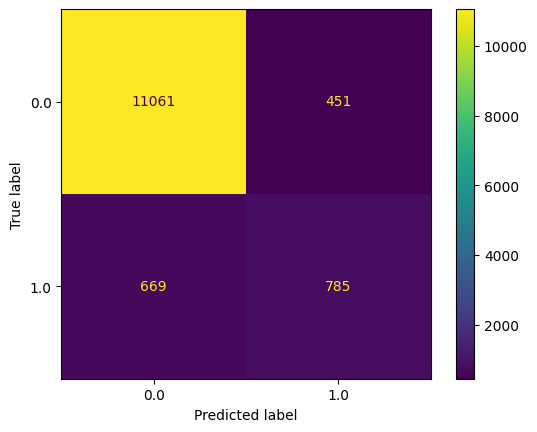

In [37]:
ConfusionMatrixDisplay.from_predictions(actual, dt_pred)

In [38]:
print(classification_report(actual, dt_pred))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     11512
         1.0       0.64      0.54      0.58      1454

    accuracy                           0.91     12966
   macro avg       0.79      0.75      0.77     12966
weighted avg       0.91      0.91      0.91     12966



### Check for accuracy

In [39]:
# import
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [40]:
eval = MulticlassClassificationEvaluator(labelCol = 'yIndex',
                                         metricName = 'accuracy')

In [41]:
print('Accuracy', eval.evaluate(predictions))

Accuracy 0.9136202375443467


## Using Logistic Regression

In [42]:
from pyspark.ml.classification import LogisticRegression

In [43]:
lr = LogisticRegression(featuresCol = 'features',
                        labelCol = 'yIndex',
                        maxIter=1000)

In [44]:
lr_model = lr.fit(train_data)

In [45]:
lr_predictions = lr_model.transform(test_data)

In [46]:
lr_predictions.show(5)

+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+--------------------+--------------------+--------------------+----------+
|_c0|age|education|               date|duration|campaign|pdays|previous|emp_var_rate|cons_price_idx|cons_conf_idx|euribor_3m|nr_employed|  y|jobs|maritals|default_one_hot|housing_one_hot| loan_one_hot|contact_one_hot|poutcome_one_hot|yIndex|            features|       rawPrediction|         probability|prediction|
+---+---+---------+-------------------+--------+--------+-----+--------+------------+--------------+-------------+----------+-----------+---+----+--------+---------------+---------------+-------------+---------------+----------------+------+--------------------+--------------------+--------------------+----------+
|  4| 33|        7|2008-05-05 00:00:00|     198|    

In [47]:
lr_pred = lr_predictions.select('prediction').toPandas()

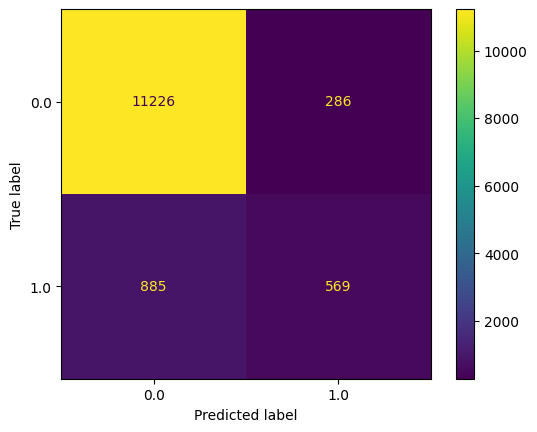

In [48]:
ConfusionMatrixDisplay.from_predictions(actual, lr_pred)

In [49]:
eval_lr = MulticlassClassificationEvaluator(labelCol = 'yIndex',
                                         metricName = 'accuracy')

In [50]:
print('Accuracy', eval_lr.evaluate(lr_predictions))

Accuracy 0.9096868733610982


In [51]:
ml_df.show()

NameError: name 'ml_df' is not defined

In [52]:
print(major_df.count()/minor_df.count()*100)

NameError: name 'major_df' is not defined

## Oversampling to reduce imbalance in _'yIndex'_

In [53]:
# Implement oversampling method
import pyspark.sql.functions as F
import math
# only take needed columns to model
ml_df = tele_transform.select('yIndex','features')

# calculate ratio
major_df = ml_df.filter(ml_df.yIndex == "1.0")
minor_df = ml_df.filter(ml_df.yIndex == "0.0")
ratio = int(math.ceil(major_df.count()/minor_df.count()*100))
print("ratio: {}".format(ratio))
a = range(ratio)

# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", F.explode(F.array([F.lit(x) for x in a]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)

ratio: 13


In [54]:
# split dataframe into train and test datasets
train, test = combined_df.randomSplit([0.7, 0.3], seed=42)

In [55]:
from pyspark.ml.feature import Normalizer, StandardScaler
from pyspark.ml import Pipeline
# LogisticRegression

# create transformers
scaler = StandardScaler(inputCol='features',outputCol='scaled_features')
normalizer = Normalizer(inputCol='scaled_features',outputCol='norm_scaled_features')

# set regression model
logreg =  LogisticRegression(labelCol="yIndex", featuresCol="features",maxIter=10, regParam=0.0, elasticNetParam=0)

# create pipeline
pipeline = Pipeline(stages=[logreg])

# run CV on train data
lr_pipe = pipeline.fit(train)

# create prediction column on test data
results = lr_pipe.transform(test)

# evaluate results
correct_count = results.filter(results.yIndex == results.prediction).count()
total_count = results.count()

correct_1_count = results.filter((results.yIndex == 1) & (results.prediction == 1)).count()
total_1_test = results.filter((results.yIndex == 1)).count()
total_1_predict = results.filter((results.prediction == 1)).count()

print("All correct predections count: ",correct_count)
print("Total count: ",total_count)
print("Accuracy %: ",(correct_count / total_count)*100)
print("Recall %: ",(correct_1_count / total_1_test)*100)
print("Precision %: ",(correct_1_count / total_1_predict)*100)

All correct predections count:  298266
Total count:  301340
Accuracy %:  98.97988982544635
Recall %:  1.2474012474012475
Precision %:  13.846153846153847


In [56]:
from pyspark.ml.classification import RandomForestClassificationModel, RandomForestClassifier
# RandomForestClassifier

# set rf model
rf =  RandomForestClassifier(labelCol="yIndex", featuresCol="features")

# instantiate pipeline
pipeline = Pipeline(stages=[rf])

# train model
model_rf = pipeline.fit(train)

# create prediction column on test data
results = model_rf.transform(test)

# evaluate results
correct_count = results.filter(results.yIndex == results.prediction).count()
total_count = results.count()

correct_1_count = results.filter((results.yIndex == 1) & (results.prediction == 1)).count()
total_1_test = results.filter((results.yIndex == 1)).count()
total_1_predict = results.filter((results.prediction == 1)).count()

print("All correct predections count: ",correct_count)
print("Total count: ",total_count)
print("Accuracy %: ",(correct_count / total_count)*100)
print("Recall %: ",(correct_1_count / total_1_test)*100)
print("Precision %: ",(correct_1_count / total_1_predict)*100)

All correct predections count:  298454
Total count:  301340
Accuracy %:  99.04227782571182
Recall %:  0.0


ZeroDivisionError: division by zero